In [42]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [43]:
#read in raw data
df = pd.read_csv("Google Nonbrand Auto Paid Search.csv", parse_dates=['month'], index_col='month')

In [44]:
#define target variable y and exogenous factors
y = df['cpq']
exog = df[['spend', 'troas_flag', 'acquisition_cut']]

In [45]:
#use auto arima to find the best parameters
model = auto_arima(
    y,
    exogenous=exog,
    start_p=0, max_p=3,           # AR terms
    start_q=0, max_q=3,           # MA terms
    d=None,                       # Auto-differencing
    seasonal=True,                # Seasonal component
    m=12,                         # Seasonal period (monthly data)
    start_P=0, max_P=2,           # Seasonal AR terms
    start_Q=0, max_Q=2,           # Seasonal MA terms
    D=None,                       # Seasonal differencing
    stepwise=True,                # Stepwise search for faster computation
    trace=True,                   # Show progress
    error_action="ignore",        # Ignore errors
    suppress_warnings=True        # Suppress warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=350.747, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=345.251, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=349.096, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=352.246, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=345.291, Time=0.15 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=345.413, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=344.864, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=353.741, Time=0.05 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=342.355, Time=0.15 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=

In [46]:
#check summary of auto_arima model
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -165.178
Date:                            Fri, 06 Dec 2024   AIC                            342.355
Time:                                    12:24:53   BIC                            351.687
Sample:                                01-01-2022   HQIC                           345.576
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -38.3821      8.623     -4.451      0.000     -55.282     -21.482
ar.L1         -0.3865      0.267   

In [47]:
#use the parameters suggested by auto_arima to fit SARIMAX model
order = model.order
seasonal_order = model.seasonal_order

sarimax_model = SARIMAX(
    y,
    exog=exog,
    order=order,
    seasonal_order=seasonal_order
)

fitted_model = sarimax_model.fit(disp=False)
print(fitted_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                cpq   No. Observations:                   36
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -164.725
Date:                            Fri, 06 Dec 2024   AIC                            345.449
Time:                                    12:25:07   BIC                            357.892
Sample:                                01-01-2022   HQIC                           349.744
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
spend            8.221e-05   2.36e-05      3.485      0.000     3.6e-05       0.000
troas_flag        -3

In [48]:
#import test data (2025 dates and exogenous factors)
df_test = pd.read_csv("Google Nonbrand Auto Paid Search (2025 Test Data).csv", parse_dates=['month'], index_col='month')

In [49]:
#define exogenous factor for test data
exog_test = df_test[['spend', 'troas_flag', 'acquisition_cut']]

In [50]:
#forecast for 2025 with exogenous factors
forecast = fitted_model.get_forecast(steps=len(df_test), exog=exog_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [53]:
forecast_mean

2025-01-01     83.114348
2025-02-01     77.012465
2025-03-01    101.551284
2025-04-01     94.970350
2025-05-01     94.005602
2025-06-01     89.641013
2025-07-01     87.778739
2025-08-01     91.946252
2025-09-01     90.046850
2025-10-01     83.901099
2025-11-01     81.963993
2025-12-01     86.722160
Freq: MS, Name: predicted_mean, dtype: float64

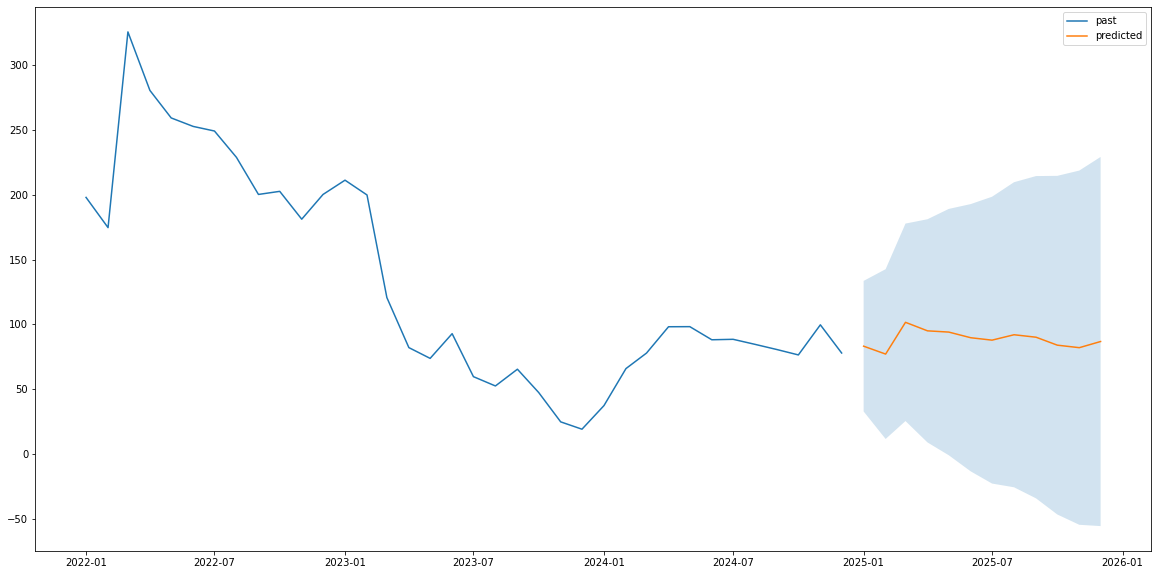

In [52]:
plt.figure(figsize=(20,10))

plt.plot(df.index, y, label='past')

#plot the prediction means as line
plt.plot(forecast_mean.index, forecast_mean, label='predicted')

#shade between the confidence intervals
plt.fill_between(forecast_mean.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], alpha=0.2)

#plot legend and show figure
plt.legend()
plt.show()

In [55]:
date_range = pd.date_range(start="2015-01-01", end="2023-12-01", freq="MS")
sales_data = np.random.normal(200, 10, len(date_range)) + np.sin(np.linspace(0, 2*np.pi, len(date_range)) * 5)
inflation_data = np.random.uniform(1.5, 3.5, len(date_range))

In [56]:
inflation_data

array([1.93465471, 2.61696633, 1.62418998, 3.01022345, 2.84699165,
       3.12146704, 1.84736812, 2.01089654, 2.15496858, 1.91962396,
       2.50864381, 2.03062037, 3.03199977, 2.69404837, 3.16513133,
       1.51249136, 1.56746807, 2.10248726, 3.31205768, 3.47667614,
       2.39085443, 2.55428588, 1.55969461, 1.65514052, 2.96006177,
       2.99643388, 2.36929373, 3.36859663, 1.84603574, 3.46905306,
       1.66113246, 1.59608757, 2.00318018, 3.22464566, 2.96236944,
       3.00734691, 2.49169252, 1.62453059, 3.49327541, 2.30620279,
       1.80630646, 2.54271234, 3.25317517, 1.72173361, 2.87958482,
       3.30517375, 2.22877197, 1.76940942, 2.10288952, 3.33632972,
       2.24191375, 2.63957772, 1.743009  , 2.78322863, 3.23443551,
       3.33190206, 2.85577551, 2.09243087, 1.99131144, 2.17589476,
       1.53421318, 3.43082775, 3.36721422, 3.46214586, 3.19648196,
       2.8645954 , 2.32772856, 2.70097803, 2.4656338 , 2.92539548,
       3.42035647, 1.70038435, 3.2754046 , 1.57418219, 3.23073